## Content  
1. [Separate variants by pathogenicity value](#1.-Separate-variants-by-pathogenicity-value)
2. [Balance dataframes](#2.-Balance-dataframes)
3. [Visualize the distribution of cDNA positions relative to the transcripts boundaries](#3.-Visualize-the-distribution-of-cDNA-positions-relative-to-the-transcripts-boundaries)
4. [Get sequence context](#4.-Get-sequence-context)
5. [Build a sequence logo](#5.-Build-a-sequence-logo)
6. [Statistical comparison of positions in contexts](#6.-Statistical-comparison-of-positions-in-contexts)

In [1]:
import datetime
import json
from os.path import join

import logomaker as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyliftover
import seaborn as sns
import seqlogo
from Bio.Seq import Seq
from pyfaidx import Fasta
from scipy.stats import chi2_contingency

from analysis_functions import (
                        get_cdna_percentage,
                        calculate_chi2_p_values,
                        filter_and_convert_to_list,
                        check_ref,
                        get_codon_position,
                        get_context
                    )

## 1. Separate variants by pathogenicity value

Create dataframes for pathogenic/benign variants based on frequency.

* **pathogenic**  
 Cutoff in AC < 2. Additionally, intersect with the options in ClinVar and add pathogenic/likely pathogenic variants that are missing in GnomAD v.4, but are in ClinVar.

* **benign**  
 AC cut-off >= 2 (according to recent ACGS guidelines, BS2 criterion). In this case, we may have many autosomal recessive variants left, so let’s remove them. To do this, compare the resulting dataframe with benign ClinVar variants and remove all intersections with registered P/LP variants.

ClinVar does not contain transcripts for the variants, so first annotate the downloaded Clinvar file (GRCh38 version) with VEP. 

In [2]:
nmd_undergo_df = pd.read_csv("data/nmd_undergo_df.csv")

In [3]:
pat_nmd_undergo = nmd_undergo_df.query('AC < 2')

In [4]:
ben_nmd_undergo = nmd_undergo_df.query('AC >= 2')

### Remove all pathogenic Clinvar variants from benign dataframe

Merge `clinvar_nmd_undergo_df` and `ben_nmd_undergo` dataframes, remove all intersections by `CHROM`, `POS`, `REF`, `ALT`, and then remove the remainder of `clinvar_nmd_undergo_df` (i.e. remove all rows that do not have an empty `CLNSIG` column).

In [5]:
clinvar_nmd_undergo_df = pd.read_csv("data/clinvar_nmd_undergo_df.csv")
clinvar_nmd_undergo = clinvar_nmd_undergo_df.rename(columns={'Feature': 'Canonical_transcript'})

In [6]:
merged_clinvar_and_ben_undergo = pd.concat([ben_nmd_undergo, clinvar_nmd_undergo], ignore_index=True)
merged_clinvar_and_ben_undergo

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2025660,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2028164,rs1441225021,C,G,HIGH,stop_gained,GABRD,ENST00000378585,642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,2029236,rs1405824159,C,T,HIGH,stop_gained,GABRD,ENST00000378585,896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,2228818,rs1225111926,C,T,HIGH,stop_gained,SKI,ENST00000378536,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,2511342,.,A,C,HIGH,stop_gained,PANK4,ENST00000378466,1838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8899,chr22,50721740,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,3958,...,545051.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8900,chr22,50722004,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4222,...,2663911.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8901,chr22,50722235,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,4453,...,422407.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8902,chr22,50722255,NaN,G,A,NaN,stop_gained,NaN,ENST00000262795,4473,...,1675899.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [7]:
# remove duplicates
ben_nmd_undergo_filtered = merged_clinvar_and_ben_undergo.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep=False)
ben_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2025660,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2028164,rs1441225021,C,G,HIGH,stop_gained,GABRD,ENST00000378585,642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,2029236,rs1405824159,C,T,HIGH,stop_gained,GABRD,ENST00000378585,896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,2228818,rs1225111926,C,T,HIGH,stop_gained,SKI,ENST00000378536,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,2511342,.,A,C,HIGH,stop_gained,PANK4,ENST00000378466,1838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8899,chr22,50721740,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,3958,...,545051.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8900,chr22,50722004,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4222,...,2663911.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8901,chr22,50722235,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,4453,...,422407.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8902,chr22,50722255,NaN,G,A,NaN,stop_gained,NaN,ENST00000262795,4473,...,1675899.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [8]:
# remove the Clinvar df
ben_nmd_undergo_filtered = ben_nmd_undergo_filtered[~ben_nmd_undergo_filtered['CLNSIG'].notna()]
ben_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2025660,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2028164,rs1441225021,C,G,HIGH,stop_gained,GABRD,ENST00000378585,642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,2029236,rs1405824159,C,T,HIGH,stop_gained,GABRD,ENST00000378585,896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,2228818,rs1225111926,C,T,HIGH,stop_gained,SKI,ENST00000378536,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,2511342,.,A,C,HIGH,stop_gained,PANK4,ENST00000378466,1838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473,chr22,50600868,.,C,A,HIGH,stop_gained,MAPK8IP2,ENST00000329492,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3474,chr22,50720238,.,C,A,HIGH,stop_gained,SHANK3,ENST00000262795,2456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3475,chr22,50720534,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,2752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3476,chr22,50721521,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
ben_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape', 'ID',
       'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 'Gene', 'Feature_type',
       'BIOTYPE', 'CANONICAL'],
      dtype='object')

Remove unnecessary columns left after Clinvar.

In [10]:
ben_nmd_undergo_filtered = ben_nmd_undergo_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 
                                                'Gene', 'Feature_type', 'BIOTYPE', 'CANONICAL'])
ben_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,2025660,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,471,HC,NaN,NaN,2.0,0.245,1.000000,NO
1,chr1,2028164,rs1441225021,C,G,HIGH,stop_gained,GABRD,ENST00000378585,642,HC,NaN,NaN,3.0,0.245,1.000000,NO
2,chr1,2029236,rs1405824159,C,T,HIGH,stop_gained,GABRD,ENST00000378585,896,HC,NaN,NaN,5.0,0.245,1.000000,NO
3,chr1,2228818,rs1225111926,C,T,HIGH,stop_gained,SKI,ENST00000378536,500,HC,NaN,NaN,2.0,0.194,0.950938,NO
4,chr1,2511342,.,A,C,HIGH,stop_gained,PANK4,ENST00000378466,1838,HC,NaN,NaN,2.0,0.304,0.694764,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473,chr22,50600868,.,C,A,HIGH,stop_gained,MAPK8IP2,ENST00000329492,76,HC,NaN,NaN,2.0,0.100,0.775794,NO
3474,chr22,50720238,.,C,A,HIGH,stop_gained,SHANK3,ENST00000262795,2456,HC,NaN,NaN,3.0,0.123,1.000000,NO
3475,chr22,50720534,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,2752,HC,NaN,NaN,2.0,0.123,1.000000,NO
3476,chr22,50721521,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3739,HC,NaN,NaN,5.0,0.123,1.000000,NO


Before filtering:

In [11]:
ben_nmd_undergo.shape

(3478, 17)

Add position in codon for each variant.

In [12]:
ben_nmd_undergo_filtered['cDNA_position'] = ben_nmd_undergo_filtered['cDNA_position'].astype(int)

ben_nmd_undergo_filtered['Codon_position'] = np.where(ben_nmd_undergo_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(ben_nmd_undergo_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

ben_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position
0,chr1,2025660,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,471,HC,NaN,NaN,2.0,0.245,1.000000,NO,3
1,chr1,2028164,rs1441225021,C,G,HIGH,stop_gained,GABRD,ENST00000378585,642,HC,NaN,NaN,3.0,0.245,1.000000,NO,3
2,chr1,2029236,rs1405824159,C,T,HIGH,stop_gained,GABRD,ENST00000378585,896,HC,NaN,NaN,5.0,0.245,1.000000,NO,2
3,chr1,2228818,rs1225111926,C,T,HIGH,stop_gained,SKI,ENST00000378536,500,HC,NaN,NaN,2.0,0.194,0.950938,NO,2
4,chr1,2511342,.,A,C,HIGH,stop_gained,PANK4,ENST00000378466,1838,HC,NaN,NaN,2.0,0.304,0.694764,NO,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473,chr22,50600868,.,C,A,HIGH,stop_gained,MAPK8IP2,ENST00000329492,76,HC,NaN,NaN,2.0,0.100,0.775794,NO,1
3474,chr22,50720238,.,C,A,HIGH,stop_gained,SHANK3,ENST00000262795,2456,HC,NaN,NaN,3.0,0.123,1.000000,NO,2
3475,chr22,50720534,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,2752,HC,NaN,NaN,2.0,0.123,1.000000,NO,1
3476,chr22,50721521,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3739,HC,NaN,NaN,5.0,0.123,1.000000,NO,1


**The dataframe with benign variants is ready.**

### Add all non-population pathogenic Clinvar variants to the pathogenic dataframe

Now add to `pat_nmd_undergo` variants that are P/LP according to ClinVar and are not found in the GnomAD v4 database.

In [13]:
pat_nmd_undergo.shape[0] + clinvar_nmd_undergo.shape[0]

15827

In [14]:
merged_clinvar_and_pat = pat_nmd_undergo.merge(clinvar_nmd_undergo, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', indicator=True)
merged_clinvar_and_pat

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge
0,chr1,1825438,rs867938404,G,A,HIGH,stop_gained,GNB1,ENST00000378609,379.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,chr1,2024966,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,172.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,2024966,.,C,G,HIGH,stop_gained,GABRD,ENST00000378585,172.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,2024993,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,199.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,2025553,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,364.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15489,chr22,50721740,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000251322,Transcript,ENST00000262795,protein_coding,3958.0,YES,0.123,1.0,NO,right_only
15490,chr22,50722004,NaN,G,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4222.0,YES,0.123,1.0,NO,right_only
15491,chr22,50722235,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4453.0,YES,0.123,1.0,NO,right_only
15492,chr22,50722255,NaN,G,A,NaN,NaN,NaN,NaN,NaN,...,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4473.0,YES,0.123,1.0,NO,right_only


In [15]:
pat_nmd_undergo_filtered = merged_clinvar_and_pat.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep='first', ignore_index=True)

In [16]:
duplicates = pat_nmd_undergo_filtered[pat_nmd_undergo_filtered.duplicated(subset=['CHROM', 'POS', 'ALT'], keep=False)]
duplicates

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge


In [17]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL',
       'Gene', 'Feature_type', 'Canonical_transcript_y', 'BIOTYPE',
       'cDNA_position_y', 'CANONICAL', 'LOEUF_y', 'pext_y', 'NMD_escape_y',
       '_merge'],
      dtype='object')

In [18]:
pat_nmd_undergo_filtered['Canonical_transcript_x'] = pat_nmd_undergo_filtered['Canonical_transcript_x'].fillna(pat_nmd_undergo_filtered['Canonical_transcript_y'])
pat_nmd_undergo_filtered['cDNA_position_x'] = pat_nmd_undergo_filtered['cDNA_position_x'].fillna(pat_nmd_undergo_filtered['cDNA_position_y'])
pat_nmd_undergo_filtered['Consequence_x'] = pat_nmd_undergo_filtered['Consequence_x'].fillna(pat_nmd_undergo_filtered['Consequence_y'])
pat_nmd_undergo_filtered['LOEUF_x'] = pat_nmd_undergo_filtered['LOEUF_x'].fillna(pat_nmd_undergo_filtered['LOEUF_y'])
pat_nmd_undergo_filtered['Gene_symbol'] = pat_nmd_undergo_filtered['Gene_symbol'].fillna(pat_nmd_undergo_filtered['SYMBOL'])
pat_nmd_undergo_filtered['NMD_escape_x'] = pat_nmd_undergo_filtered['NMD_escape_x'].fillna(pat_nmd_undergo_filtered['NMD_escape_y'])
pat_nmd_undergo_filtered['pext_x'] = pat_nmd_undergo_filtered['pext_x'].fillna(pat_nmd_undergo_filtered['pext_y'])

In [19]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL',
       'Gene', 'Feature_type', 'Canonical_transcript_y', 'BIOTYPE',
       'cDNA_position_y', 'CANONICAL', 'LOEUF_y', 'pext_y', 'NMD_escape_y',
       '_merge'],
      dtype='object')

In [20]:
pat_nmd_undergo_filtered = pat_nmd_undergo_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 
                                                'SYMBOL', 'Gene', 'Feature_type', 'Canonical_transcript_y', 
                                                'BIOTYPE', 'cDNA_position_y', 'CANONICAL', '_merge', 'LOEUF_y', 'NMD_escape_y', 'pext_y'])

pat_nmd_undergo_filtered = pat_nmd_undergo_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 
                                                  'Canonical_transcript_x': 'Canonical_transcript', 
                                                  'Consequence_x': 'Consequence', 'LOEUF_x': 'LOEUF', 
                                                  'NMD_escape_x':'NMD_escape', 'pext_x': 'pext'})
pat_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,1825438,rs867938404,G,A,HIGH,stop_gained,GNB1,ENST00000378609,379.0,HC,NaN,NaN,1.0,0.145,0.966547,NO
1,chr1,2024966,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,172.0,HC,NaN,NaN,1.0,0.245,1.000000,NO
2,chr1,2024966,.,C,G,HIGH,stop_gained,GABRD,ENST00000378585,172.0,HC,NaN,NaN,1.0,0.245,1.000000,NO
3,chr1,2024993,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,199.0,HC,NaN,NaN,1.0,0.245,1.000000,NO
4,chr1,2025553,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,364.0,HC,NaN,NaN,1.0,0.245,1.000000,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15489,chr22,50721740,NaN,C,T,NaN,stop_gained,SHANK3,ENST00000262795,3958.0,NaN,NaN,NaN,NaN,0.123,1.000000,NO
15490,chr22,50722004,NaN,G,T,NaN,stop_gained,SHANK3,ENST00000262795,4222.0,NaN,NaN,NaN,NaN,0.123,1.000000,NO
15491,chr22,50722235,NaN,C,T,NaN,stop_gained,SHANK3,ENST00000262795,4453.0,NaN,NaN,NaN,NaN,0.123,1.000000,NO
15492,chr22,50722255,NaN,G,A,NaN,stop_gained,SHANK3,ENST00000262795,4473.0,NaN,NaN,NaN,NaN,0.123,1.000000,NO


In [21]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape'],
      dtype='object')

Before adding Clinvar variants:

In [22]:
pat_nmd_undergo.shape

(10401, 17)

Add position in codon for each variant.

In [23]:
pat_nmd_undergo_filtered['cDNA_position'] = pat_nmd_undergo_filtered['cDNA_position'].astype(int)

pat_nmd_undergo_filtered['Codon_position'] = np.where(pat_nmd_undergo_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(pat_nmd_undergo_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

pat_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position
0,chr1,1825438,rs867938404,G,A,HIGH,stop_gained,GNB1,ENST00000378609,379,HC,NaN,NaN,1.0,0.145,0.966547,NO,1
1,chr1,2024966,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,172,HC,NaN,NaN,1.0,0.245,1.000000,NO,1
2,chr1,2024966,.,C,G,HIGH,stop_gained,GABRD,ENST00000378585,172,HC,NaN,NaN,1.0,0.245,1.000000,NO,1
3,chr1,2024993,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,199,HC,NaN,NaN,1.0,0.245,1.000000,NO,1
4,chr1,2025553,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,364,HC,NaN,NaN,1.0,0.245,1.000000,NO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15489,chr22,50721740,NaN,C,T,NaN,stop_gained,SHANK3,ENST00000262795,3958,NaN,NaN,NaN,NaN,0.123,1.000000,NO,1
15490,chr22,50722004,NaN,G,T,NaN,stop_gained,SHANK3,ENST00000262795,4222,NaN,NaN,NaN,NaN,0.123,1.000000,NO,1
15491,chr22,50722235,NaN,C,T,NaN,stop_gained,SHANK3,ENST00000262795,4453,NaN,NaN,NaN,NaN,0.123,1.000000,NO,1
15492,chr22,50722255,NaN,G,A,NaN,stop_gained,SHANK3,ENST00000262795,4473,NaN,NaN,NaN,NaN,0.123,1.000000,NO,3


**The dataframe with pathogenic variants is ready.**

## 2. Balance dataframes

In both dataframes, we will leave only those genes that are found in both `ben_nmd_undergo_filtered` and `pat_nmd_undergo_filtered`, and also equalize the number of variants in each gene.

In [24]:
unique_genes_ben = ben_nmd_undergo_filtered['Gene_symbol'].unique()
unique_genes_pat = pat_nmd_undergo_filtered['Gene_symbol'].unique()
intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))


Unique genes in pat dataframe: 1415
Unique genes in ben dataframe: 917
Intersected genes: 900


In [25]:
common_genes = set(unique_genes_ben) & set(unique_genes_pat)

ben_nmd_undergo_filtered = ben_nmd_undergo_filtered[ben_nmd_undergo_filtered['Gene_symbol'].isin(common_genes)]
pat_nmd_undergo_filtered = pat_nmd_undergo_filtered[pat_nmd_undergo_filtered['Gene_symbol'].isin(common_genes)]

In [26]:
unique_genes_pat = pat_nmd_undergo_filtered['Gene_symbol'].unique()
unique_genes_ben = ben_nmd_undergo_filtered['Gene_symbol'].unique()

intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))

Unique genes in pat dataframe: 900
Unique genes in ben dataframe: 900
Intersected genes: 900


In [27]:
count_pat = pat_nmd_undergo_filtered['Gene_symbol'].value_counts()
count_ben = ben_nmd_undergo_filtered['Gene_symbol'].value_counts()

min_counts = pd.concat([count_pat, count_ben], axis=1).min(axis=1)

pat_nmd_undergo_final = pd.concat([
    pat_nmd_undergo_filtered[pat_nmd_undergo_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])

ben_nmd_undergo_final = pd.concat([
    ben_nmd_undergo_filtered[ben_nmd_undergo_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])


In [28]:
pat_nmd_undergo_final.shape == ben_nmd_undergo_final.shape

True

In [29]:
pat_nmd_undergo_final['Gene_symbol'].nunique() == ben_nmd_undergo_final['Gene_symbol'].nunique()

True

In [30]:
pat_nmd_undergo_final['Gene_symbol'].value_counts().sum() == ben_nmd_undergo_final['Gene_symbol'].value_counts().sum()

True

In [31]:
pat_nmd_undergo_final['Gene_symbol'].nunique()

900

Dataframes are now balanced by genes and number of variants.

## 3. Get sequence context

Write the context in the corresponding column of the dataframe.

In [32]:
transcript_fasta = Fasta("data_dir/gencode_data/gencode.v45.transcripts.fa.gz", key_function = lambda x: x.split('.')[0])

Get contexts.

In [33]:
get_context(ben_nmd_undergo_final, transcript_fasta, 13, 12)

'Contexts have been added to the dataframe!'

In [34]:
get_context(pat_nmd_undergo_final, transcript_fasta, 13, 12)

'Contexts have been added to the dataframe!'

In [36]:
pat_nmd_undergo_final['Strand'] = pat_nmd_undergo_final.apply(check_ref, axis=1)
pat_nmd_undergo_final['Strand'].value_counts()

Strand
+              1650
-              1500
Not_defined       2
Name: count, dtype: int64

In [37]:
ben_nmd_undergo_final['Strand'] = ben_nmd_undergo_final.apply(check_ref, axis=1)
ben_nmd_undergo_final['Strand'].value_counts()

Strand
+              1650
-              1501
Not_defined       1
Name: count, dtype: int64

In [38]:
pat_nmd_undergo_final = pat_nmd_undergo_final[pat_nmd_undergo_final['Strand'] != 'Not_defined']
ben_nmd_undergo_final = ben_nmd_undergo_final[ben_nmd_undergo_final['Strand'] != 'Not_defined']

Get codon positions of variants.

In [39]:
pat_nmd_undergo_final['Codon_position'] = pat_nmd_undergo_final.apply(get_codon_position, axis=1)
pat_nmd_undergo_final['Codon_position'].value_counts()

Codon_position
1          2006
3           611
2           532
No_stop       1
Name: count, dtype: int64

In [40]:
ben_nmd_undergo_final['Codon_position'] = ben_nmd_undergo_final.apply(get_codon_position, axis=1)
ben_nmd_undergo_final['Codon_position'].value_counts()

Codon_position
1          2493
3           335
2           321
No_stop       2
Name: count, dtype: int64

In [41]:
pat_nmd_undergo_final = pat_nmd_undergo_final[pat_nmd_undergo_final['Codon_position'] != 'No_stop']
ben_nmd_undergo_final = ben_nmd_undergo_final[ben_nmd_undergo_final['Codon_position'] != 'No_stop']

Divide dataframes depending on codon position.

In [42]:
ben_nmd_undergo_final_1 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 1].copy()
ben_nmd_undergo_final_2 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 2].copy()
ben_nmd_undergo_final_3 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 3].copy()

In [43]:
pat_nmd_undergo_final_1 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 1].copy()
pat_nmd_undergo_final_2 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 2].copy()
pat_nmd_undergo_final_3 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 3].copy()

## 4. Visualize the distribution of cDNA positions relative to the transcripts boundaries

Get a dictionary with transcript lengths and write the % location of the variant into a dataframe.

In [44]:
pat_nmd_undergo_final['Percent_position'] = pat_nmd_undergo_final.apply(get_cdna_percentage, axis=1)
ben_nmd_undergo_final['Percent_position'] = ben_nmd_undergo_final.apply(get_cdna_percentage, axis=1)

Visualize the distribution of variants.

In [45]:
pat_nmd_undergo_final_sorted = pat_nmd_undergo_final.copy()
pat_nmd_undergo_final_sorted['CHROM'] = pat_nmd_undergo_final_sorted['CHROM'].str.extract(r'(\d+)')
pat_nmd_undergo_final_sorted = pat_nmd_undergo_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

In [46]:
ben_nmd_undergo_final_sorted = ben_nmd_undergo_final.copy()
ben_nmd_undergo_final_sorted['CHROM'] = ben_nmd_undergo_final_sorted['CHROM'].str.extract(r'(\d+)')
ben_nmd_undergo_final_sorted = ben_nmd_undergo_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

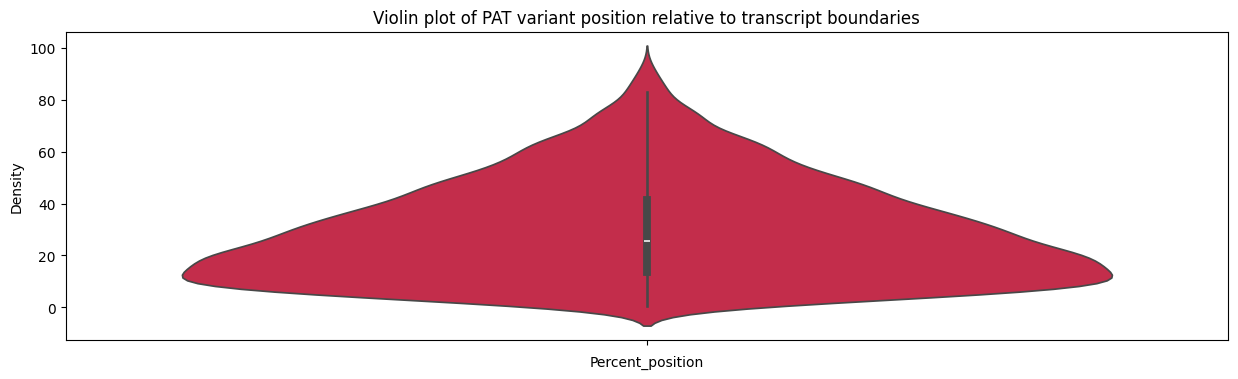

In [47]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=pat_nmd_undergo_final_sorted, color='crimson')
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

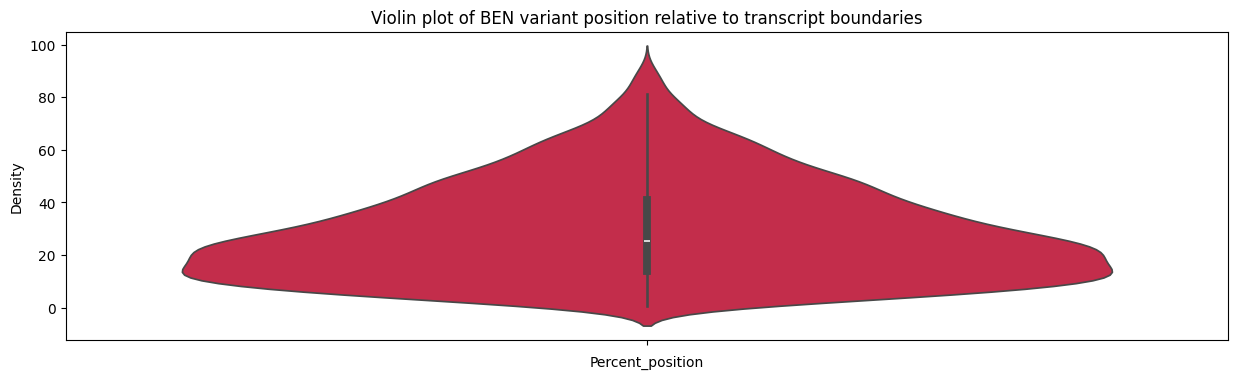

In [48]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=ben_nmd_undergo_final_sorted, color='crimson')
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

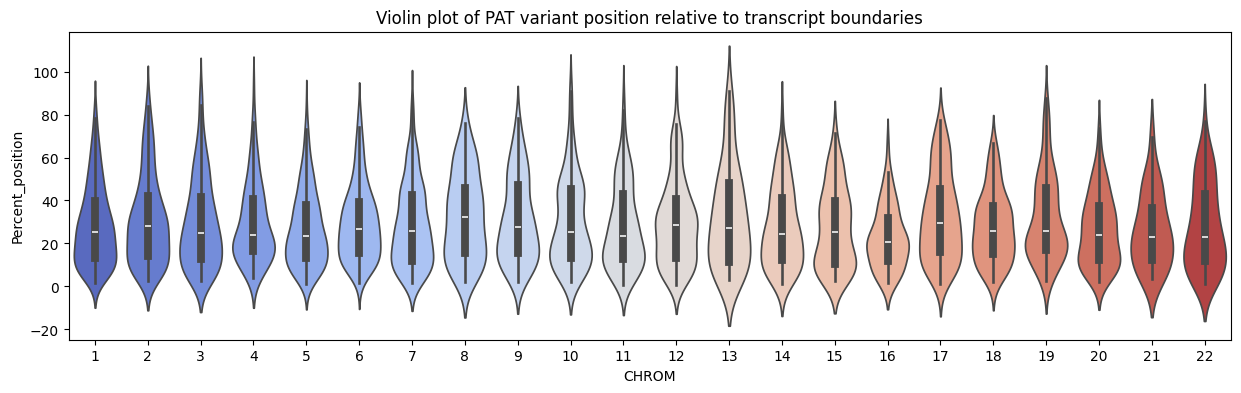

In [49]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=pat_nmd_undergo_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

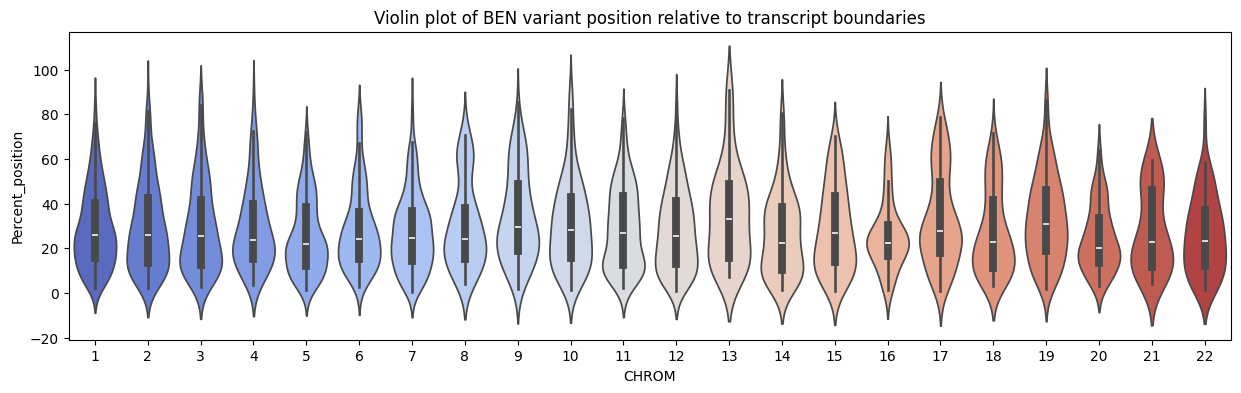

In [50]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=ben_nmd_undergo_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

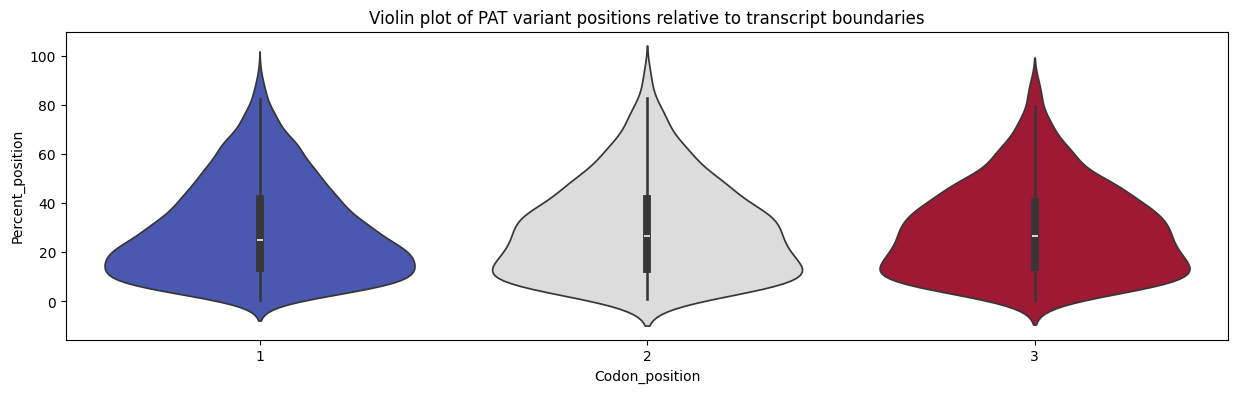

In [51]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=pat_nmd_undergo_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant positions relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

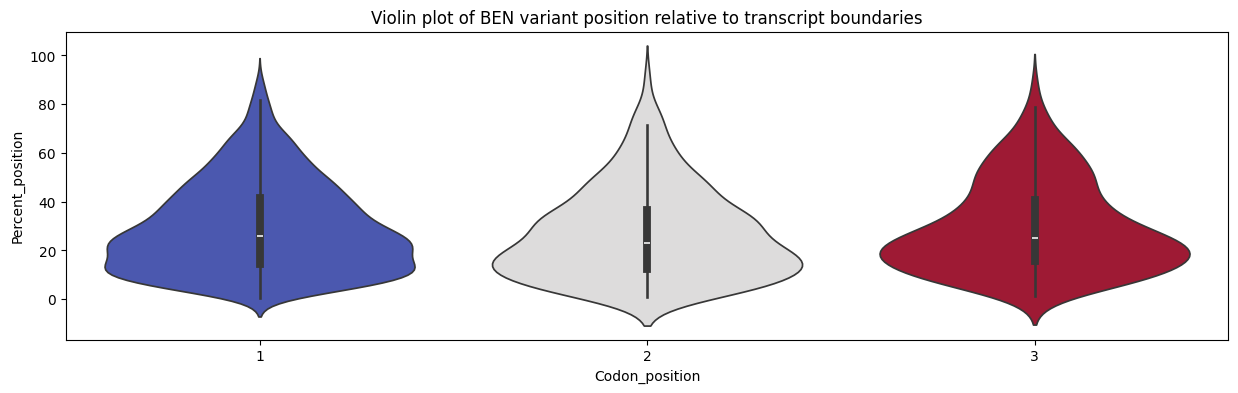

In [52]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=ben_nmd_undergo_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

## 5. Build a sequence logo

In [53]:
filtered_context_ben_1 = filter_and_convert_to_list(ben_nmd_undergo_final_1['Context'])
filtered_context_ben_2 = filter_and_convert_to_list(ben_nmd_undergo_final_2['Context'])
filtered_context_ben_3 = filter_and_convert_to_list(ben_nmd_undergo_final_3['Context'])

In [54]:
filtered_context_pat_1 = filter_and_convert_to_list(pat_nmd_undergo_final_1['Context'])
filtered_context_pat_2 = filter_and_convert_to_list(pat_nmd_undergo_final_2['Context'])
filtered_context_pat_3 = filter_and_convert_to_list(pat_nmd_undergo_final_3['Context'])

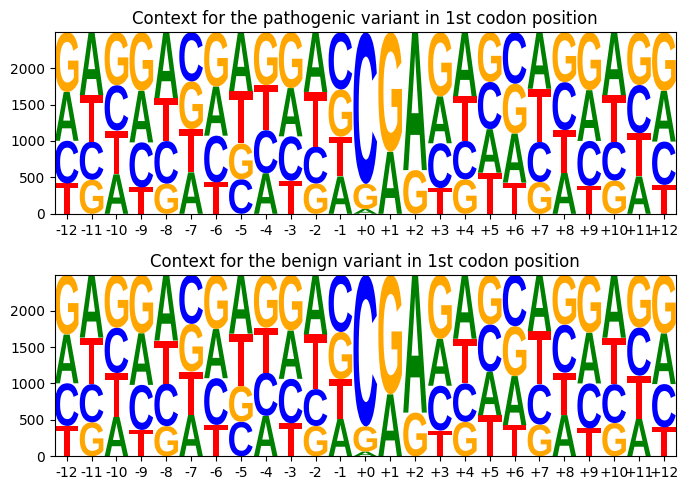

In [55]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_context_pat_1)
counts_mat_ben_1 = lm.alignment_to_matrix(filtered_context_ben_1)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_1, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
pat_logo.ax.set_title('Context for the pathogenic variant in 1st codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_1, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
ben_logo.ax.set_title('Context for the benign variant in 1st codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/1st_pos_context_nmd_escape.png', bbox_inches='tight')

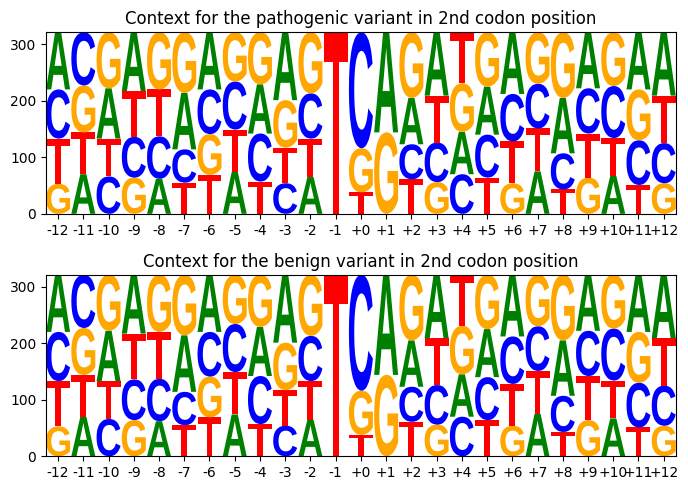

In [56]:
counts_mat_pat_2 = lm.alignment_to_matrix(filtered_context_pat_2)
counts_mat_ben_2 = lm.alignment_to_matrix(filtered_context_ben_2)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_2, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
pat_logo.ax.set_title('Context for the pathogenic variant in 2nd codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_2, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
ben_logo.ax.set_title('Context for the benign variant in 2nd codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/2nd_pos_context_nmd_escape.png', bbox_inches='tight')

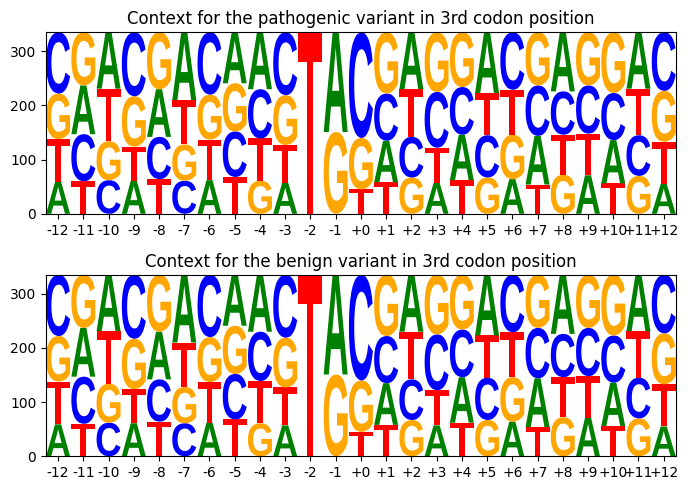

In [57]:
counts_mat_pat_3 = lm.alignment_to_matrix(filtered_context_pat_3)
counts_mat_ben_3 = lm.alignment_to_matrix(filtered_context_ben_3)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_3, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
pat_logo.ax.set_title('Context for the pathogenic variant in 3rd codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_3, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
ben_logo.ax.set_title('Context for the benign variant in 3rd codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/3rd_pos_context_nmd_escape.png', bbox_inches='tight')

## 6. Statistical comparison of positions in contexts

Calculate chi-squares for each position when comparing two matrices (for pathogenic and benign contexts).

In [58]:
from scipy.stats import chi2_contingency

def calculate_chi2_p_values(context_ben, context_pat):
    """
    Calculate chi-squared values and p-values for two sets of context sequences.

    Args:
        context_ben (List[str]): List of context sequences for benign samples.
        context_pat (List[str]): List of context sequences for pathogenic samples.

    Returns:
        Tuple[List[float], List[float]]: Chi-squared values and p-values.
    """
    sequences_array_ben = np.array(context_ben)
    sequences_array_pat = np.array(context_pat)

    freq_array_ben = np.zeros((len(sequences_array_ben[0]), 4))
    freq_array_pat = np.zeros((len(sequences_array_pat[0]), 4))

    for seq in sequences_array_ben:
        for j, nt in enumerate(seq):
            if nt == 'A':
                freq_array_ben[j][0] += 1
            elif nt == 'C':
                freq_array_ben[j][1] += 1
            elif nt == 'G':
                freq_array_ben[j][2] += 1
            elif nt == 'T':
                freq_array_ben[j][3] += 1

    for seq in sequences_array_pat:
        for j, nt in enumerate(seq):
            if nt == 'A':
                freq_array_pat[j][0] += 1
            elif nt == 'C':
                freq_array_pat[j][1] += 1
            elif nt == 'G':
                freq_array_pat[j][2] += 1
            elif nt == 'T':
                freq_array_pat[j][3] += 1

    chi2_values = []
    p_values = []

    for i in range(freq_array_pat.shape[0]):
        contingency_table = np.array([freq_array_pat[i], freq_array_ben[i]])
        try:
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
        except ValueError as e:
            # установка псевдо-значения p-value в случае ошибки
            chi2_values.append(np.nan)
            p_values.append(1.0)
        else:
            chi2_values.append(chi2)
            p_values.append(p_value)

    return chi2_values, p_values

In [59]:
chi2_values_1, p_values_1 = calculate_chi2_p_values(filtered_context_ben_1, filtered_context_pat_1)
for i, (chi2, p_value) in enumerate(zip(chi2_values_1, p_values_1)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")

Position 0: Chi-square = 0.0, p-value = 1.0
Position 1: Chi-square = 0.0, p-value = 1.0
Position 2: Chi-square = 0.0, p-value = 1.0
Position 3: Chi-square = 0.0, p-value = 1.0
Position 4: Chi-square = 0.0, p-value = 1.0
Position 5: Chi-square = 0.0, p-value = 1.0
Position 6: Chi-square = 0.0, p-value = 1.0
Position 7: Chi-square = 0.0, p-value = 1.0
Position 8: Chi-square = 0.0, p-value = 1.0
Position 9: Chi-square = 0.0, p-value = 1.0
Position 10: Chi-square = 0.0, p-value = 1.0
Position 11: Chi-square = 0.0, p-value = 1.0
Position 12: Chi-square = nan, p-value = 1.0
Position 13: Chi-square = nan, p-value = 1.0
Position 14: Chi-square = nan, p-value = 1.0
Position 15: Chi-square = 0.0, p-value = 1.0
Position 16: Chi-square = 0.0, p-value = 1.0
Position 17: Chi-square = 0.0, p-value = 1.0
Position 18: Chi-square = 0.0, p-value = 1.0
Position 19: Chi-square = 0.0, p-value = 1.0
Position 20: Chi-square = 0.0, p-value = 1.0
Position 21: Chi-square = 0.0, p-value = 1.0
Position 22: Chi-squ

In [60]:
chi2_values_2, p_values_2 = calculate_chi2_p_values(filtered_context_ben_2, filtered_context_pat_2)
for i, (chi2, p_value) in enumerate(zip(chi2_values_2, p_values_2)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")

Position 0: Chi-square = 0.0, p-value = 1.0
Position 1: Chi-square = 0.0, p-value = 1.0
Position 2: Chi-square = 0.0, p-value = 1.0
Position 3: Chi-square = 0.0, p-value = 1.0
Position 4: Chi-square = 0.0, p-value = 1.0
Position 5: Chi-square = 0.0, p-value = 1.0
Position 6: Chi-square = 0.0, p-value = 1.0
Position 7: Chi-square = 0.0, p-value = 1.0
Position 8: Chi-square = 0.0, p-value = 1.0
Position 9: Chi-square = 0.0, p-value = 1.0
Position 10: Chi-square = 0.0, p-value = 1.0
Position 11: Chi-square = nan, p-value = 1.0
Position 12: Chi-square = nan, p-value = 1.0
Position 13: Chi-square = nan, p-value = 1.0
Position 14: Chi-square = 0.0, p-value = 1.0
Position 15: Chi-square = 0.0, p-value = 1.0
Position 16: Chi-square = 0.0, p-value = 1.0
Position 17: Chi-square = 0.0, p-value = 1.0
Position 18: Chi-square = 0.0, p-value = 1.0
Position 19: Chi-square = 0.0, p-value = 1.0
Position 20: Chi-square = 0.0, p-value = 1.0
Position 21: Chi-square = 0.0, p-value = 1.0
Position 22: Chi-squ

In [61]:
chi2_values_3, p_values_3 = calculate_chi2_p_values(filtered_context_ben_3, filtered_context_pat_3)
for i, (chi2, p_value) in enumerate(zip(chi2_values_3, p_values_3)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")

Position 0: Chi-square = 0.0, p-value = 1.0
Position 1: Chi-square = 0.0, p-value = 1.0
Position 2: Chi-square = 0.0, p-value = 1.0
Position 3: Chi-square = 0.0, p-value = 1.0
Position 4: Chi-square = 0.0, p-value = 1.0
Position 5: Chi-square = 0.0, p-value = 1.0
Position 6: Chi-square = 0.0, p-value = 1.0
Position 7: Chi-square = 0.0, p-value = 1.0
Position 8: Chi-square = 0.0, p-value = 1.0
Position 9: Chi-square = 0.0, p-value = 1.0
Position 10: Chi-square = nan, p-value = 1.0
Position 11: Chi-square = nan, p-value = 1.0
Position 12: Chi-square = nan, p-value = 1.0
Position 13: Chi-square = 0.0, p-value = 1.0
Position 14: Chi-square = 0.0, p-value = 1.0
Position 15: Chi-square = 0.0, p-value = 1.0
Position 16: Chi-square = 0.0, p-value = 1.0
Position 17: Chi-square = 0.0, p-value = 1.0
Position 18: Chi-square = 0.0, p-value = 1.0
Position 19: Chi-square = 0.0, p-value = 1.0
Position 20: Chi-square = 0.0, p-value = 1.0
Position 21: Chi-square = 0.0, p-value = 1.0
Position 22: Chi-squ

## Relationship between the significance of a variant and its position in a codon¶

In [64]:
pat_nmd_undergo_final.loc[:, 'Significance'] = 'pathogenic'
ben_nmd_undergo_final.loc[:, 'Significance'] = 'benign'

In [65]:
all_nmd_undergo_final = pd.concat([pat_nmd_undergo_final, ben_nmd_undergo_final], ignore_index=True)

In [66]:
all_nmd_undergo_final = all_nmd_undergo_final.loc[all_nmd_undergo_final['Codon_position'] != 'No_stop']

In [67]:
all_nmd_undergo_final.to_csv('data/all_nmd_undergo_final.csv', index=False)

In [70]:
cross_tab_undergo = pd.crosstab(all_nmd_undergo_final['Significance'], all_nmd_undergo_final['Codon_position'])
print(cross_tab_undergo)

Codon_position     1    2    3
Significance                  
benign          2493  321  335
pathogenic      2006  532  611


In [71]:
chi2, p_value, _, _ = chi2_contingency(cross_tab_undergo)
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p_value}")

Chi-squared value: 185.4336847067887
P-value: 5.414856931679903e-41


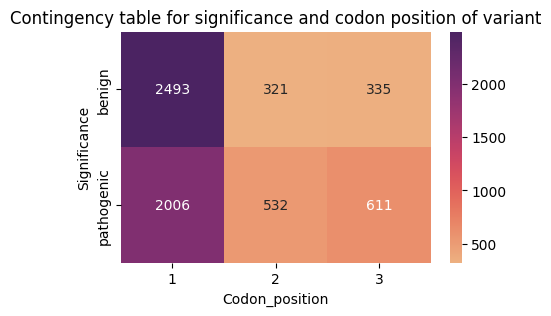

In [72]:
plt.figure(figsize=(5, 3))
sns.heatmap(cross_tab_undergo, annot=True, cmap='flare', fmt='d', cbar=True)
plt.title('Contingency table for significance and codon position of variant')
plt.xlabel('Codon_position')
plt.ylabel('Significance')
plt.show()


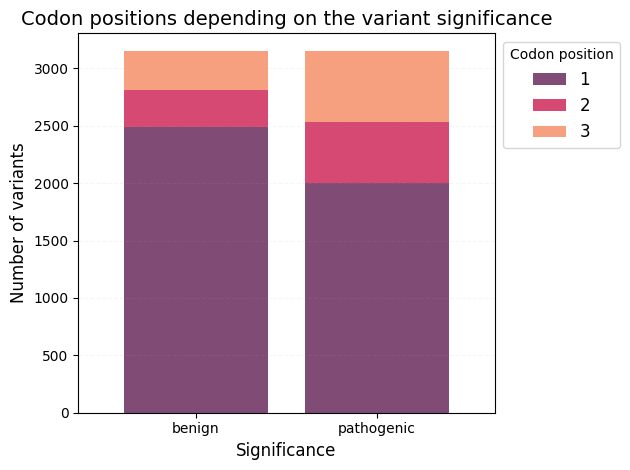

In [73]:
palette = sns.color_palette("rocket", len(cross_tab_undergo.columns))
ax = cross_tab_undergo.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='none', width=0.8, color=palette)

plt.title('Codon positions depending on the variant significance', fontsize=14)
plt.xlabel('Significance', fontsize=12)
plt.ylabel('Number of variants', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Codon position', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.1)
plt.tight_layout()
plt.show()


## Просто из интереса

In [74]:
all_nmd_escape_final = pd.read_csv("data/all_nmd_escape_final.csv")

In [75]:
all_nmd = pd.concat([all_nmd_escape_final, all_nmd_undergo_final], ignore_index=True)

In [76]:
all_nmd

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,LoF_filter,AC,LOEUF,pext,NMD_escape,Context,Strand,Codon_position,Percent_position,Significance
0,chr6,7582690,NaN,C,T,NaN,stop_gained,DSP,ENST00000379802,5673,...,NaN,NaN,0.260,0.999478,YES,ACTCAGGTGGTACAGGAAAGAGAGA,+,1,58.502630,pathogenic
1,chr6,7585276,NaN,C,T,NaN,stop_gained,DSP,ENST00000379802,8259,...,NaN,NaN,0.260,0.999478,YES,AAGCTGTCACTTCAGGACGCAGTCT,+,1,85.170671,pathogenic
2,chr6,7585222,NaN,C,T,NaN,stop_gained,DSP,ENST00000379802,8205,...,NaN,NaN,0.260,0.999478,YES,CTTCTGGAGGCTCAGGCCTGCACAG,+,1,84.613798,pathogenic
3,chr6,87259279,NaN,C,T,NaN,stop_gained,ZNF292,ENST00000369577,5677,...,NaN,NaN,0.140,0.948588,YES,ATCACAGTTATTCAGCCAGTTTCTG,+,1,46.001134,pathogenic
4,chr18,33745315,NaN,C,T,NaN,stop_gained,ASXL3,ENST00000269197,5880,...,NaN,NaN,0.199,0.811312,YES,CAAATGAGAAAGCGAGAAAACCACC,+,1,50.000000,pathogenic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7357,chr2,218583058,.,C,T,HIGH,stop_gained,CNOT9,ENST00000273064,408,...,NaN,2.0,0.275,0.846906,NO,CTGGCATTACTGCAATGTGTAGCAT,+,1,10.680628,benign
7358,chr11,30414336,rs749259850,G,A,HIGH,stop_gained,MPPED2,ENST00000358117,1091,...,NaN,2.0,0.199,0.865709,NO,CCTCTAGGTTTTCGAGACTGGGTTC,-,1,42.583919,benign
7359,chr15,44497064,.,G,T,HIGH,stop_gained,CTDSPL2,ENST00000260327,976,...,NaN,2.0,0.174,0.805590,NO,CCACTGACAGAAGAACAACTAAATA,+,1,15.171771,benign
7360,chr3,43340483,rs889935483,C,T,HIGH,stop_gained,SNRK,ENST00000296088,1232,...,NaN,3.0,0.132,0.949558,NO,GACATAGCGGATCGAGACGCCATTG,+,1,23.747109,benign


In [77]:
cross_tab_all = pd.crosstab([all_nmd['Significance'], all_nmd['Codon_position']], all_nmd['NMD_escape'])
print(cross_tab_all)

NMD_escape                     NO  YES
Significance Codon_position           
benign       1               2493  387
             2                321   80
             3                335   65
pathogenic   1               2006  350
             2                532  102
             3                611   80


In [78]:
chi2, p_value, _, _ = chi2_contingency(cross_tab_all)
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p_value}")

Chi-squared value: 19.549466586364556
P-value: 0.0015178321964894723
